# Analyze Real-Estate Sales and Selling Agents
Having scraped a large amount of real-estate transaction data around our property we can now proceed to analyze it. Remember the objective: we're trying to get the best price for our property. Also we don't want a long sales cycle so there might be a tradeoff there.

![Dunphy Realtor](https://pmcvariety.files.wordpress.com/2013/09/bench-2.jpg?w=600)

In [83]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
import folium
from folium import plugins
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

In [84]:
# read in the data we scraped, setting the index to the zpid
df = pd.read_csv('comps.csv').set_index('zpid')
df.drop(columns='Unnamed: 0',inplace=True)

In [85]:
df.columns

Index(['address', 'zipcode', 'latitude', 'longitude', 'beds', 'baths', 'area',
       'dateSold', 'yearBuilt', 'lotSize', 'zestimate', 'sellingPrice',
       'sellerAgent', 'sellerAgentUrl', 'buyerAgent', 'buyerAgentUrl',
       'listedAt', 'firstListingPrice', 'timesListed', 'zEstimate_at_listing',
       'zEstimate_date', 'url'],
      dtype='object')

In [86]:
# convert date columns to dates
df['dateSold'] = pd.to_datetime(df['dateSold']).dt.date
df['listedAt'] = pd.to_datetime(df['listedAt']).dt.date
df['yearSold'] = df['dateSold'].apply(lambda x: x.year)

In [87]:
# add some features
df['zEstimate ratio'] = df['sellingPrice']/df['zEstimate_at_listing']
df['listing ratio'] = df['sellingPrice']/df['firstListingPrice']
df['days to sell'] = (df['dateSold']-df['listedAt']).dt.days
df['price per sf'] = df['sellingPrice']/df['area']

In [88]:
df.describe()

,zipcode,latitude,longitude,beds,baths,area,yearBuilt,lotSize,zestimate,sellingPrice,firstListingPrice,timesListed,zEstimate_at_listing,yearSold,zEstimate ratio,listing ratio,days to sell,price per sf
count,371.000000,371.000000,371.000000,371.000000,370.000000,371.000000,371.000000,371.000000,3.700000e+02,3.710000e+02,3.260000e+02,371.000000,3.700000e+02,371.000000,370.000000,326.000000,326.000000,371.000000
mean,94062.700809,37.468741,-122.257547,3.859838,3.270946,2756.714286,1957.614555,14533.959569,2.442315e+06,2.474591e+06,2.443018e+06,0.951482,2.399295e+06,2018.401617,1.058250,1.026278,67.202454,954.992293
std,2.678135,0.011096,0.013183,0.765315,0.963634,888.390494,146.461783,14860.918327,4.529166e+05,4.124915e+05,4.929351e+05,0.438445,5.408213e+05,0.902188,0.187090,0.119898,52.864431,249.877025
min,94061.000000,37.443840,-122.289077,1.000000,1.000000,640.000000,-1.000000,-1.000000,1.101590e+06,2.000000e+06,1.349000e+06,0.000000,1.117838e+06,2017.000000,0.605160,0.687813,8.000000,244.491575
25%,94062.000000,37.459940,-122.267209,3.000000,3.000000,2130.000000,1950.500000,7348.000000,2.101136e+06,2.150000e+06,2.081250e+06,1.000000,2.017146e+06,2018.000000,0.938971,0.947006,34.000000,804.909401
50%,94062.000000,37.469038,-122.257941,4.000000,3.000000,2630.000000,1964.000000,10001.000000,2.346724e+06,2.365000e+06,2.388000e+06,1.000000,2.301331e+06,2018.000000,1.039822,1.004326,46.000000,926.086957
75%,94062.000000,37.479229,-122.247463,4.000000,4.000000,3194.500000,1987.000000,16223.000000,2.688632e+06,2.750000e+06,2.746500e+06,1.000000,2.714198e+06,2019.000000,1.143315,1.088255,81.000000,1081.585317
max,94070.000000,37.486600,-122.229919,6.000000,8.000000,8487.000000,2019.000000,175546.000000,4.456948e+06,3.500000e+06,4.295000e+06,2.000000,4.514336e+06,2020.000000,2.078119,1.704225,266.000000,3437.500000


Pivot the data by *sellerAgent* and sort by most sales (descending) to identify top candidates. We're particularly interested in the *zEstimate ratio* which is the ratio of the selling price to the *zEstimate* which was published just prior to the house being listed (there's evidence in the data that the *zEstimate* is impacted by a the act of listing a house).

In [91]:
df.pivot_table(
    index='sellerAgent',
    aggfunc={
       'zipcode': 'count',
       'zEstimate ratio': np.mean,
       'listing ratio': np.mean,
       'days to sell': np.mean,
       'sellingPrice': np.mean,
       'dateSold': max,
       'price per sf': np.mean
    }).rename(columns={'zipcode': 'sales', 'dateSold': 'Most recent sale'})\
    .sort_values(by='sales',ascending=False).head(20)

,Most recent sale,days to sell,listing ratio,price per sf,sellingPrice,zEstimate ratio,sales
sellerAgent,,,,,,,
John Shroyer,2020-05-18,90.777778,1.003955,913.051302,2.485250e+06,1.012065,21
Vicky Costantini,2020-03-31,81.125000,0.987836,928.717427,2.338542e+06,0.993955,10
Alex Lehr,2019-11-04,53.714286,1.021900,829.662288,2.386000e+06,1.032605,8
DeLeon Team,2019-11-26,53.571429,1.043718,1028.968548,2.751429e+06,1.017317,7
Sam Anagnostou,2019-03-28,62.166667,0.962691,843.892199,2.663571e+06,0.970424,7
David Young,2019-09-10,66.714286,1.091236,978.235441,2.217857e+06,1.093899,7
Pam Tyson,2020-02-21,135.666667,0.944210,869.944502,2.266667e+06,1.107467,6
Team Bedbury,2019-07-30,40.000000,1.024596,770.958209,2.454000e+06,0.966357,5
Joyce Romeo,2018-06-11,32.250000,1.058784,1026.338696,2.647000e+06,1.061448,5


Two agents stand out in the list above, *Laura Bertolacci* and *Lena Griffin*. They managed to get 32% and 41% uplifts respectively over Zillow's *zEstimate* that existed just prior to listing. Laura has 4 sales in our filter criteria while Lena has 3. However Laura sold her houses in an average of 48 days whereas Lena took 165 days.

It's interesting that I recognize two of the names on this list - Sam Anagnostou (friend of a friend) and Michelle Glaubert who was the original selling agent on the house we're now trying to sell. Sam has 6 transactions but he's only getting 97% of the zEstimate. Michelle has 2 and is getting 102% of the zEstimate (but with a 29 day sales cycle which is very quick). Michelle unfortunately hasn't sold a house in this range since March 2018.

Most realtors in our list only had one sale that met our filter criteria. This is apparent from the distribution of sales/realtor:

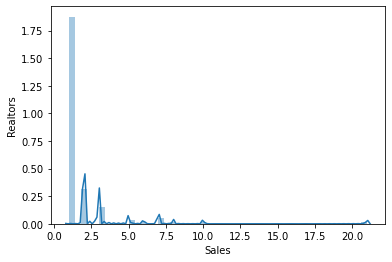

In [92]:
sns.distplot(df.pivot_table(index='sellerAgent',aggfunc={'zipcode': 'count'}))
plt.ylabel('Realtors')
plt.xlabel('Sales');

Let's look at Laura and Lena's transactions in detail:

In [93]:
df[df.sellerAgent=='Laura Bertolacci']

,address,zipcode,latitude,longitude,beds,baths,area,dateSold,yearBuilt,lotSize,zestimate,sellingPrice,sellerAgent,sellerAgentUrl,buyerAgent,buyerAgentUrl,listedAt,firstListingPrice,timesListed,zEstimate_at_listing,zEstimate_date,url,yearSold,zEstimate ratio,listing ratio,days to sell,price per sf
zpid,,,,,,,,,,,,,,,,,,,,,,,,,,,
15591898,"2641 Carolina Ave, Redwood City, CA 94061",94061,37.454586,-122.233151,4,4.0,2020,2019-11-27,1951,6041.0,2235277.0,2328000.0,Laura Bertolacci,https://www.zillow.com/profile/Laura-Bertolacci/,Rachel Ni and Jay Doker,https://www.zillow.com/profile/Jay-Rachel/,2019-10-25,2328000.0,1,1307906.0,2019-09-30,https://www.zillow.com/homedetails/2641-Caroli...,2019,1.779944,1.000000,33.0,1152.475248
15589710,"636 Lakemead Way, Emerald Hills, CA 94062",94062,37.462312,-122.268629,4,2.5,3388,2019-10-25,1988,17450.0,2985860.0,3110000.0,Laura Bertolacci,https://www.zillow.com/profile/Laura-Bertolacci/,Laura Bryant,https://www.zillow.com/profile/Laura-Bryant/,2019-08-30,3200000.0,1,2665524.0,2019-07-31,https://www.zillow.com/homedetails/636-Lakemea...,2019,1.166750,0.971875,56.0,917.945691
15571679,"817 Shepard Way, Redwood City, CA 94062",94062,37.461465,-122.258837,4,3.0,1960,2019-06-14,1969,8568.0,2291492.0,2350000.0,Laura Bertolacci,https://www.zillow.com/profile/Laura-Bertolacci/,Anthony Galli,https://www.zillow.com/profile/Anthony-Galli/,2019-05-10,2268000.0,1,2036211.0,2019-04-30,https://www.zillow.com/homedetails/817-Shepard...,2019,1.154104,1.036155,35.0,1198.979592


In [94]:
df[df.sellerAgent=='Lena Griffin']

,address,zipcode,latitude,longitude,beds,baths,area,dateSold,yearBuilt,lotSize,zestimate,sellingPrice,sellerAgent,sellerAgentUrl,buyerAgent,buyerAgentUrl,listedAt,firstListingPrice,timesListed,zEstimate_at_listing,zEstimate_date,url,yearSold,zEstimate ratio,listing ratio,days to sell,price per sf
zpid,,,,,,,,,,,,,,,,,,,,,,,,,,,
15572403,"967 Stony Hill Rd, Redwood City, CA 94061",94061,37.457506,-122.252125,4,4.0,2481,2019-06-07,1957,7701.0,2781903.0,2850000.0,Lena Griffin,https://www.zillow.com/profile/LenaGriffin/,Judy Citron,https://www.zillow.com/profile/Judy-Citron/,2019-04-19,2795000.0,1,2083781.0,2019-03-31,https://www.zillow.com/homedetails/967-Stony-H...,2019,1.367706,1.019678,49.0,1148.730351
15573311,"356 Topaz St, Redwood City, CA 94062",94062,37.472862,-122.248638,4,4.0,2024,2017-11-15,1951,7875.0,2450257.0,2410000.0,Lena Griffin,https://www.zillow.com/profile/LenaGriffin/,NaN,NaN,2017-05-11,1495000.0,2,1628781.0,2017-04-30,https://www.zillow.com/homedetails/356-Topaz-S...,2017,1.479634,1.612040,188.0,1190.711462
15573560,"588 Quartz St, Redwood City, CA 94062",94062,37.471868,-122.243155,4,4.0,2563,2017-08-25,1942,8041.0,2769378.0,2625000.0,Lena Griffin,https://www.zillow.com/profile/LenaGriffin/,NaN,NaN,2016-12-08,1549000.0,2,1888660.0,2016-11-30,https://www.zillow.com/homedetails/588-Quartz-...,2017,1.389874,1.694642,260.0,1024.190402


In [95]:
# draw a map of the zEstimate ratio for all the transactions

# the map is centered on Sancho's Taqueria out of respect for their fish tacos
m = folium.Map([37.4710361,-122.2629159], zoom_start=13)

# the heatmap plugin expects either a 2D or 3D array with columns [lat,long(,weight)]
# it also can't handle NaNs

heatmapdata = np.array(df[['latitude','longitude','zEstimate ratio']].dropna())
m.add_child(plugins.HeatMap(heatmapdata, radius=15))
m

Recall that this is the map we started with:
![map](Screen%20Shot%202020-06-05%20at%2011.36.45%20PM.png)

In [96]:
# another heatmap but this time based on selling price
# just remember that we've already filtered on selling prices between 2M and 3.5M
# so this is not the full picture

m = folium.Map([37.4710361,-122.2629159], zoom_start=13)
heatmapdata = np.array(df[['latitude','longitude','sellingPrice']].dropna())
m.add_child(plugins.HeatMap(heatmapdata, radius=10))
m

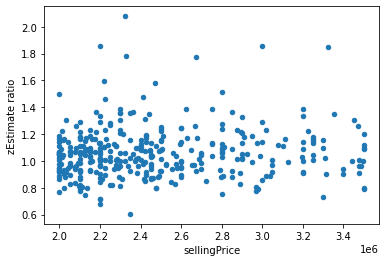

In [97]:
# look at the zEstimate ratio x sellingPrice
df.plot.scatter(x='sellingPrice',y='zEstimate ratio');

This looks reasonably random. Let's try by zipcode:

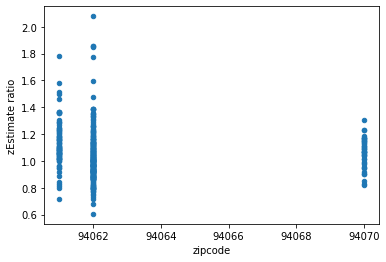

In [98]:
df.plot.scatter(x='zipcode',y='zEstimate ratio');

Thats not a particularly useful visualization, let's use histograms instead:

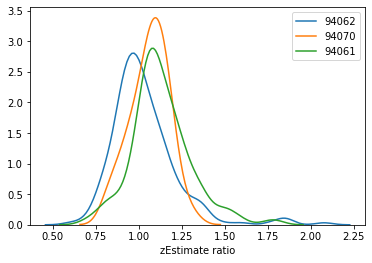

In [99]:
for zc in df.zipcode.unique():
    sns.distplot( df.loc[df.zipcode == zc,"zEstimate ratio"], label=zc, hist=False)
plt.legend();

Look at whether houses are selling above or below the original listing price. A listing ratio of 1 means the house sold for the original listing price. Higher than 1 implies multiple offers. Lower than 1 indicates the original listing price was too high to clear the market.

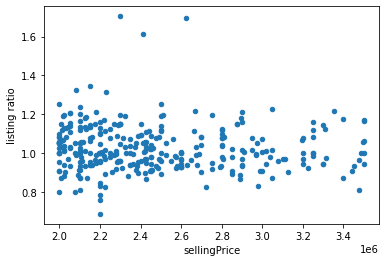

In [100]:
df.plot.scatter(x='sellingPrice',y='listing ratio');

There appears to be a bit more upside in selling price/listing price for the lower priced properties.

Look at the correlation in price and living area:

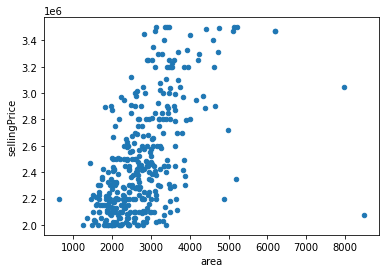

In [101]:
df.plot.scatter(x='area',y='sellingPrice');

Our property is 3000 sf, how does that compare to the houses being sold in my neighborhood in a similar price range?

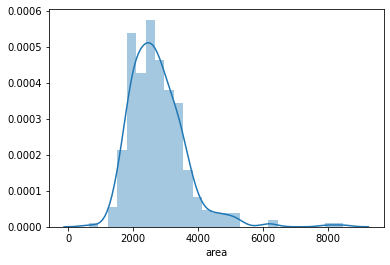

In [102]:
sns.distplot(df['area']);

House prices in Silicon Valley are often looked at in terms of price per square foot. Since we have some outliers in that dimension let's just look between \\$0 and \\$2000/sf.

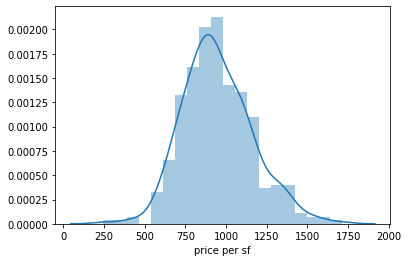

In [103]:
sns.distplot(df.loc[df['price per sf']<2000,'price per sf']);

Since we have several years of data let's look at how this distribution has evolved over time.

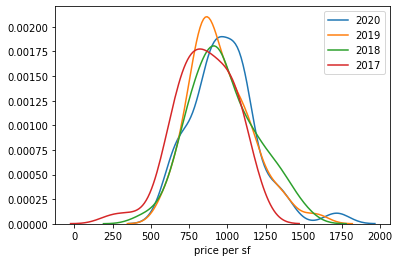

In [104]:
for y in df['yearSold'].unique():
    sns.distplot( 
        df.loc[(df.yearSold == y) &
        (df['price per sf'] < 2000),'price per sf'], label=y, hist=False)
plt.legend();

My property is in the 94062 zip code, let's narrow in on that:

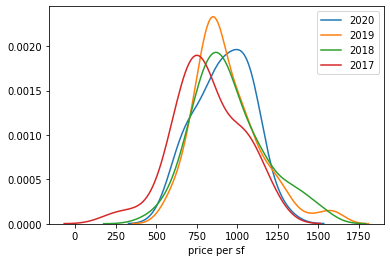

In [105]:
for y in df['yearSold'].unique():
    sns.distplot( 
        df.loc[(df.yearSold == y) & 
        (df['price per sf'] < 2000) &
        (df['zipcode'] == 94062),"price per sf"], label=y, hist=False)
plt.legend();

It appears that prices per square foot rose from 2017 to 2018, dropped very slightly in 2019, and have gone back up in 2020.

Let's examine price per square foot as a function of year built:

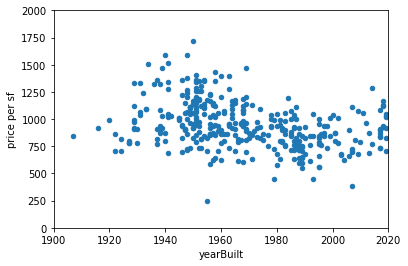

In [106]:
df.plot.scatter(x='yearBuilt',y='price per sf')
plt.xlim(1900,2020)
plt.ylim(0,2000);

It's easy to see that there are relatively few newer houses in my area, the bulk of construction appears to have happened in the late 1940s and 1990s. We can verify this with another histogram:

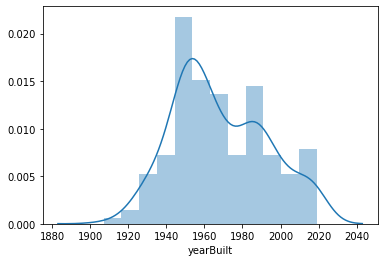

In [107]:
sns.distplot(df.loc[df['yearBuilt']>1900,'yearBuilt']);

Now let's look at how long a house stays on the market before it sells.

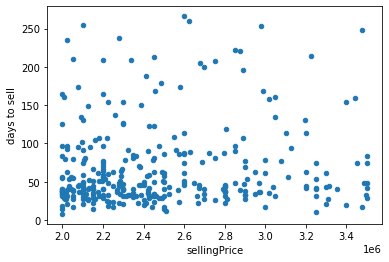

In [108]:
df.plot.scatter(x='sellingPrice',y='days to sell');

Again a histogram is in order:

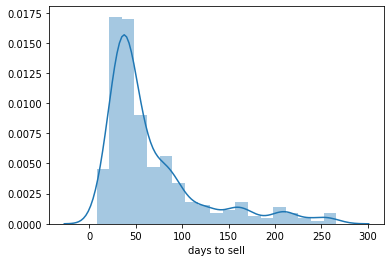

In [109]:
sns.distplot(df['days to sell']);

And for 94062 only:

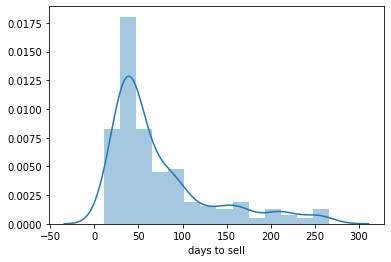

In [110]:
sns.distplot(df.loc[df['zipcode']==94062,'days to sell']);

94062 by year

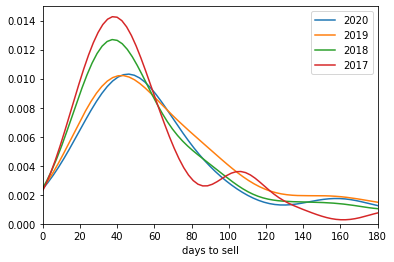

In [111]:
for y in df['yearSold'].unique():
    sns.distplot(df.loc[(df.yearSold == y) & (df['zipcode'] == 94062),'days to sell'],
                 label=y, hist=False)
plt.xlim(0,180)
plt.legend();

It's apparent that it's taking a bit longer to sell houses in 2020.

## Nearest Neighbors
Real-estate valuation is usually based on *comparables* - similar houses in the same neighborhood. We can find these based on a normalized euclidian distance between our house and all the other houses. We're not actually trying to cluster, just find the *k* nearest neighbors.

The dimensions of interest for computing the euclidian distance are:

* beds
* baths
* area
* yearBuilt
* lotSize

We'll ignore latitude and longitude for now.

In [112]:
df_norm = df[['beds','baths','area','yearBuilt','lotSize']].copy().dropna()
df_norm.describe()

,beds,baths,area,yearBuilt,lotSize
count,370.000000,370.000000,370.000000,370.000000,370.000000
mean,3.854054,3.270946,2750.962162,1957.556757,14545.670270
std,0.758187,0.963634,882.648293,146.655869,14879.327188
min,1.000000,1.000000,640.000000,-1.000000,-1.000000
25%,3.000000,3.000000,2125.000000,1950.250000,7348.000000
50%,4.000000,3.000000,2630.000000,1963.500000,10001.000000
75%,4.000000,4.000000,3186.750000,1987.000000,16235.000000
max,6.000000,8.000000,8487.000000,2019.000000,175546.000000


In [113]:
# find the -1 values
df_norm.loc[(df_norm.yearBuilt == -1) | (df_norm.lotSize == -1)]

,beds,baths,area,yearBuilt,lotSize
zpid,,,,,
2082824737,4,4.0,1983,-1,-1.0
249950101,3,1.0,1900,-1,-1.0


In [114]:
df_norm.drop(df_norm.loc[(df_norm.yearBuilt == -1) | (df_norm.lotSize == -1)].index,inplace=True)

In [115]:
df_norm.describe()

,beds,baths,area,yearBuilt,lotSize
count,368.000000,368.000000,368.000000,368.000000,368.000000
mean,3.855978,3.275136,2755.361413,1968.201087,14624.728261
std,0.758901,0.958193,883.014207,24.641689,14880.909083
min,1.000000,1.000000,640.000000,1907.000000,4146.000000
25%,3.000000,3.000000,2147.500000,1951.000000,7371.250000
50%,4.000000,3.000000,2640.000000,1964.000000,10005.500000
75%,4.000000,4.000000,3191.750000,1987.000000,16260.250000
max,6.000000,8.000000,8487.000000,2019.000000,175546.000000


In [116]:
my_house = {
    'beds': 4,
    'baths': 3.5,
    'area': 3100,
    'yearBuilt': 2008, # actually 1979 but substantially remodeled in 2008 so we'll use the newer date
    'lotSize': 9900
}
df = df.append(pd.DataFrame(my_house,index=[0]))

In [117]:
for col in df_norm.columns:
    mx = df_norm[col].max()
    mn = df_norm[col].min()
    df_norm[col] = (df_norm[col] - mn)/(mx-mn)

In [118]:
df_norm.describe()

,beds,baths,area,yearBuilt,lotSize
count,368.000000,368.000000,368.000000,368.000000,368.000000
mean,0.571196,0.325019,0.269576,0.546438,0.061136
std,0.151780,0.136885,0.112529,0.220015,0.086820
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.285714,0.192112,0.392857,0.018817
50%,0.600000,0.285714,0.254874,0.508929,0.034186
75%,0.600000,0.428571,0.325188,0.714286,0.070678
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [119]:
# convert the dataframe to an array
array_norm = np.array(df_norm)

# now pull the house off the end of the dataframe
my_house_norm = array_norm[-1:]
array_norm = array_norm[:-1]
df_norm = df_norm[:-1]

# compute the euclidian distances from all the houses to my house
df_norm['dist'] = euclidean_distances(array_norm, my_house_norm)

In [120]:
# now we can get the nearest neighbors
top5_neighbors = df_norm.sort_values(by='dist').head()

Having found the 5 nearest neighbors based on normalized euclidian distances we can now look at the actual properties:

In [121]:
df.iloc[df.index.isin(top5_neighbors.index)]

,address,zipcode,latitude,longitude,beds,baths,area,dateSold,yearBuilt,lotSize,zestimate,sellingPrice,sellerAgent,sellerAgentUrl,buyerAgent,buyerAgentUrl,listedAt,firstListingPrice,timesListed,zEstimate_at_listing,zEstimate_date,url,yearSold,zEstimate ratio,listing ratio,days to sell,price per sf
15571972,"860 Piedmont Way, Redwood City, CA 94062",94062.0,37.464813,-122.251883,4,3.0,2470,2019-06-20,1958,7379.0,2045912.0,2100000.0,Violaine Mraihi,https://www.zillow.com/profile/violaine/,Tom He,https://www.zillow.com/profile/loan2home/,2019-05-02,2075000.0,1.0,2071242.0,2019-04-30,https://www.zillow.com/homedetails/860-Piedmon...,2019.0,1.013884,1.012048,49.0,850.202429
15572403,"967 Stony Hill Rd, Redwood City, CA 94061",94061.0,37.457506,-122.252125,4,4.0,2481,2019-06-07,1957,7701.0,2781903.0,2850000.0,Lena Griffin,https://www.zillow.com/profile/LenaGriffin/,Judy Citron,https://www.zillow.com/profile/Judy-Citron/,2019-04-19,2795000.0,1.0,2083781.0,2019-03-31,https://www.zillow.com/homedetails/967-Stony-H...,2019.0,1.367706,1.019678,49.0,1148.730351
15572400,"985 Stony Hill Rd, Redwood City, CA 94061",94061.0,37.457251,-122.251437,4,4.0,2340,2018-05-15,1957,7971.0,2108630.0,2200000.0,NaN,NaN,Lily Miao,https://www.zillow.com/profile/Lily-Miao/,2018-04-16,1898000.0,1.0,2023002.0,2018-03-31,https://www.zillow.com/homedetails/985-Stony-H...,2018.0,1.087493,1.159115,29.0,940.170940
15572528,"991 Cambridge Rd, Redwood City, CA 94061",94061.0,37.455176,-122.253486,4,3.0,2425,2018-04-10,1958,8585.0,2218030.0,2300000.0,NaN,NaN,Judy Citron,https://www.zillow.com/profile/Judy-Citron/,2018-03-09,1925000.0,1.0,1909479.0,2018-02-28,https://www.zillow.com/homedetails/991-Cambrid...,2018.0,1.204517,1.194805,32.0,948.453608
15572386,"920 Pleasant Hill Rd, Redwood City, CA 94061",94061.0,37.458685,-122.253234,4,4.0,2590,2017-10-12,1956,8799.0,2271192.0,2200000.0,Sandy Rostad,https://www.zillow.com/profile/user7604814/,Debbie Sharp,https://www.zillow.com/profile/The-Sharp-Group/,2017-08-17,2099000.0,1.0,2157239.0,2017-07-31,https://www.zillow.com/homedetails/920-Pleasan...,2017.0,1.019822,1.048118,56.0,849.420849
